# PHYS 381 - Assignment #3
#### February 12, 2018
John Ming Ngo (30020834)

Kenneth Barry Sharman (00300185)

## Introduction
This week we will be looking at the details involved with performing integration using python.

There are many functions within SciPy that will take care of the integration details, such as the quad function. However, our goal at this point is to get an underlying understanding of the process. To begin, we went through the details of using the well-known trapezoidal approximation for evaluating an integral. This analysis is key to our understanding the numerical integral, as all functions will use this basic idea of a limit.  We revealed that two important aspects of numerical integration are the number of divisions and the error involved. We will keep these at the top of our list throughout our analysis.

The first goal is to use Scipy's romberg function to compute the value of the following triple integral.


$$ \int_{x=0}^1 \int_{y=0}^\sqrt{1-x^2} \int_{z=0}^\sqrt{1-x^2-y^2} \frac{dz \, dy \, dx}{1 + x^2 + y^2 + z^2} $$

After getting comfortable with using the romberg function to take a single integral, we noted that the task at hand was to determine how to perform consecutive integrations using a function that can only do one at a time.

The solution to this problem is to create a chain of integrations. It is essential to understand that the argument of the romberg function is an unevaluated function which returns a number. Romberg itself is an unevaluated function that returns a number. Therefore, we can create a chain of integrations which accomplishes the desired three dimensional integral.

The following chunk of code defines the functions necessary to evaluate a triple integral given input bounds.

In [1]:
import scipy.integrate as integrate
import scipy
import numpy

def tripleIntegral(integrandFunction, xLowBound, xHighBound, yLowBound, yHighBound, zLowBound, zUpBound, tol = 1e-6, divmax = 100, isShow = False):
    """
    This function computes a triple integral given an integrand function, numerical bounds on the outermost function (x),
    and function bounds on the second inner and innermost functions, with the input expected to be arranged in (y, x) order.
    
    Parameters:
        integrandFunction: The function to be integrated over.
        xLowBound: Number corresponding to the outer x integral lower bound.
        xHighBound: Number corresponding to the outer x integral higher bound.
        yLowBound: Function corresponding to the second inner y integral lower bound.
        yHighBound: Function corresponding to the second inner y integral higher bound.
        zLowBound: Function corresponding to the innermost z integral lower bound.
        zUpBound: Function corresponding to the innermost z integral higher bound.
        tol: Integration tolerances for all three integrations, as fed into the scipy.integrate.romberg function.
        divmax: divmax tolerances for all three integrations, as fed into the scipy.integrate.romberg function.
        isShow: Show the triangular integration matrix for the romberg function, for all integrals.
        
    
    Returns:
        The numerical result of the triple integral.
    """
    def outerIntegral(x):
        low, high = yLowBound(x), yHighBound(x)
        return integrate.romberg(innerIntegral, low, high, args=(x,), tol = tol, divmax = divmax, show = isShow)
    def innerIntegral(y,x):
        low, high = zLowBound(y,x), zUpBound(y,x)
        return integrate.romberg(integrandFunction, low, high, args=(y,x), tol = tol, divmax = divmax, show = isShow)
    return integrate.romberg(outerIntegral, xLowBound, xHighBound, tol = tol, divmax = divmax, show = isShow)

We will define the following functions to provide our integration bounds and integrand for the cartesian integration. Through trial and error, we realized that absolute value had to be used for the square root functions. Even though our bounds are expected to yield a non-negative radicand, we repeatedly received an invalid number error. This is since the integration is evaluated in steps, coupled with the non-exact nature of float data types. It appears we were stepping just past valid range of the radicand; hence the absolute value was necessary. 

This is not the only solution and is perhaps a dangerous one. We know that our bounds are mathematically valid, however one could use our function on an interval that lies outside of the function domain. A better solution could be to trim the bounds, with a specified allowance, such that integrating outside of the domain would throw an exception. However, for this assignment we will simply apply the absolute value.

Note that we have added a counter, which is used to keep track of the number of calls to the integrand. This will be a source of interest later in the analysis.

In [2]:

def zeroFunction(x = 0, y = 0, z = 0):
    """
    Zero function which takes any three parameters and just returns zero.
    
    Parameters:
        x, y, z: any three parameters, exist for generality sake in case some
        function wants to substitute things into this function without knowing
        beforehand that it does not need to or cannot. Meant for the triple
        integral function above.
    Returns:
        0, the integer value.
    """
    return 0

def middleCartesianHigherBounds(x):
    """
    For the cartesian integrand function, the upper bounds of the middle integral
    is calculated with this function. Note that due to floating point imprecision
    issues, the returned value might sometimes be outside the intended bounds.
    
    Since this function is not meant to be a general use function, but rather
    was made specifically for the case of that one integral, fixing it with an
    absolute value.
    
    Parameters:
        x: corresponds to the x value as subbed in by the outer integral loop.
    Returns:
        The value of the upper limit evaluated at the given x value.
    """
    return abs(1-x**2)**(1/2)

def innerCartesianHigherBounds(y,x):
    """
    For the cartesian integrand function, the upper bounds of the inner integral
    is calculated with this function. Note that due to floating point imprecision
    issues, the returned value might sometimes be outside the intended bounds.
    
    Since this function is not meant to be a general use function, but rather
    was made specifically for the case of that one integral, fixing it with an
    absolute value.
    
    Parameters:
        y: corresponds to the y value as subbed in by the middle interal loop.
        x: corresponds to the x calue as subbed in by the outer integral loop.
    Returns:
    """
    return abs(1-x**2-y**2)**(1/2)

def cartesianFunction(z,y,x):
    """
    The cartesian form of the integrand function as desired by the problem.
    
    Parameters:
        z: Corresponds to the z value to be subbed in from the innermost loop.
        y: Corresponds to the y value to be subbed in from the middle loop.
        x: Corresponds to the x value to be subbed in from the outermost loop.
    Returns:
        A value corresponding to the integrand evalulated at the given
        x, y and z variables.
    
    """
    cartesianFunction.numOfIterations += 1
    return 1/(1+x**2+y**2+z**2)
#Function attributes need to be defined after defining a function, else odd things happen.
cartesianFunction.numOfIterations = 0

Before evaluating the integral, a second integration will be defined.

In previous assignments there was a significant emphasis on the idea that equivalent mathematical statements can produce different results when using numerical methods. We will apply this concept by evaluating the previous integration in spherical coordinates.

$$ \int_{\theta=0}^{\pi/2} \int_{\phi=0}^{\pi/2} \int_{\rho=0}^1 \frac{\rho^2 \sin\phi \, d\rho \, d\phi \, d\theta}{1 + \rho^2} $$

Similar to the cartesian integral, the bounds are defined as functions.

In [3]:
def halfPiFunction(z=0,y=0,x=0):
    """
    Similar to the zero function, takes up to three arbitrary parameters
    and returns a constant value, in this case pi/2.
    
    Parameters:
        z, y, x: Parameters corresponding to the subbed in z, y, x values
        during integration, though it actually doesn't matter what's subbed
        in since it's not used. As before, these slots exist to allow the
        integral function to be fully general.
    Returns:
        scipy.pi/2 as a floating point value.
    """
    return scipy.pi/2
def oneFunction(z=0,y=0,x=0):
    """
    Similar to the zero function, takes up to three arbitrary parameters
    and returns a constant value, in this case 1.
    
    Parameters:
        z, y, x: Parameters corresponding to the subbed in z, y, x values
        during integration, though it actually doesn't matter what's subbed
        in since it's not used. As before, these slots exist to allow the
        integral function to be fully general.
    Returns:
        1.
    """
    return 1
def sphericalFunction(p, theta, phi):
    """
    The spherical form of the integrand function as desired by the problem.
    
    Parameters:
        z: Corresponds to the z value to be subbed in from the innermost loop.
        y: Corresponds to the y value to be subbed in from the middle loop.
        x: Corresponds to the x value to be subbed in from the outermost loop.
    Returns:
        A value corresponding to the integrand evalulated at the given
        x, y and z variables.
    """
    sphericalFunction.numOfIterations += 1
    return p**2*scipy.sin(phi)/(1+p**2)
#Function attributes need to be defined after the function, else odd things happen.
sphericalFunction.numOfIterations = 0

In [4]:
print("Result of the Cartesian Triple Integral:", tripleIntegral(cartesianFunction, 0, 1, zeroFunction, middleCartesianHigherBounds, zeroFunction, innerCartesianHigherBounds))
print("Result of the Spherical Triple Integral:", tripleIntegral(sphericalFunction, 0, scipy.pi/2, zeroFunction, halfPiFunction, zeroFunction, oneFunction))

Result of the Cartesian Triple Integral: 0.3370953613758728
Result of the Spherical Triple Integral: 0.3370957758099527


As expected the integration results are dependent on the coordinate system. To verify that we are on the right track, we will compare our result to that of the tplquad function found in the scipy library. The cartesianFunction is used (defined above) and bounds are defined as follows:

In [5]:
def gfun(x):
    return 0
def hfun(x):
    return numpy.sqrt(numpy.abs(1-x*x))
def qfun(x,y):
    return 0
def rfun(x,y):
    return numpy.sqrt(numpy.abs(1-x*x-y*y))

In [6]:
print("Tplquad Integral Result:", scipy.integrate.tplquad(cartesianFunction, 0, 1, gfun, hfun, qfun, rfun, args=(), epsabs=1.49e-08, epsrel=1.49e-08))

Tplquad Integral Result: (0.3370957766592014, 5.438126766630307e-09)


If this result represents the true value of the integral, it is noted that the spherical integral produced a more precise result than the cartesian, at the set tolerance level. 

It is easy to say that we want the most precise result possible, however our study of numerical methods has shown that this comes with a price- computational efficiency. In previous assignments we have timed the evaluation to compare methods. Since both integrals are evaluated using the same method, we can relate efficiency to the number of calls to the integrand. Plotting the number of integrand calls against the tolerance of the romberg function, we can provide a qualitative description of the relationship between the two variables. 

The analysis will be performed for both integrals using the counter we added to the code of each integrand function. We will define a function that stores the number of calls at a given tolerance. This data will then be plotted using a logarithmic scale, as trial and error has shown that the relationship is of a decreasing exponential form. 

In [7]:
import matplotlib.pyplot as plt

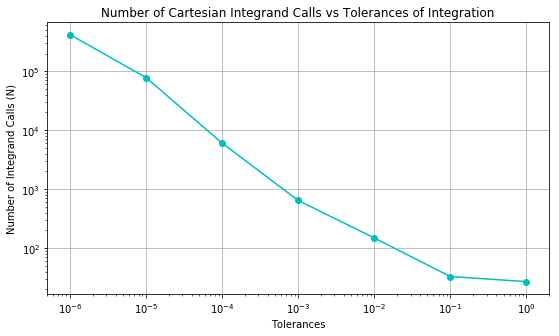

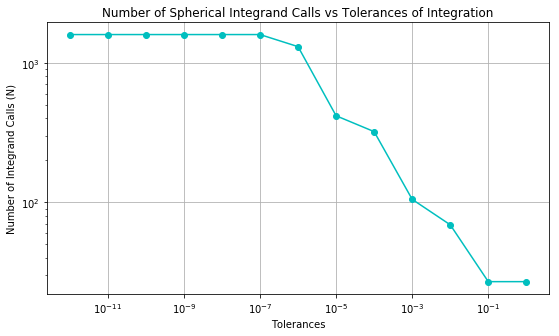

In [8]:
def getNumOfIntegrandCalls(tol, isCartesian):
    """
    This function, given a tolerance setting and an indication of if we're using
    the cartesian or spherical coordinate function determines how many integrand
    calls occurred before we get the result. It's specific to the two functions
    made above unfortunately.
    
    Parameters:
         tol: A number such as 1e-6 for the purposes of determining error tolerance
         to substitute into our integral calculation calls.
         isCartesian: A boolean flag variable for determining if to use the cartesian
         function or the spherical function.
    Returns:
        numOfCalls: The number of calls to the integrand function.
    """
    numOfCalls = 0
    if isCartesian:
        cartesianFunction.numOfIterations = 0
        tripleIntegral(cartesianFunction, 0, 1, zeroFunction, middleCartesianHigherBounds, zeroFunction, innerCartesianHigherBounds, tol = tol)
        numOfCalls = cartesianFunction.numOfIterations
    else:
        sphericalFunction.numOfIterations = 0
        tripleIntegral(sphericalFunction, 0, scipy.pi/2, zeroFunction, halfPiFunction, zeroFunction, oneFunction, tol = tol)
        numOfCalls = sphericalFunction.numOfIterations
    return numOfCalls

def createTolVsIntegrandCallsPlot(tolerances, isCartesian = True):
    """
    This function, given an input list of tolerances and an indication of which graph we
    want (cartesian or spherical), will plot a graph of the number of times the integrand
    was called versus the tolerance required.
    
    Parameters:
        tolerances: A list or numpy array of tolerances.
        isCartesian: A boolean control flag to determine if we want the graph
        for the cartesian form or the spherical form.
    """
    #Gets data points of the number of integrand calls needed for each
    #input tolerance level.
    numbersOfIterations = []
    for entry in tolerances:
        numbersOfIterations.append(getNumOfIntegrandCalls(entry, isCartesian))
        
    # Set the plot size
    plt.figure(figsize=(9,5))
        
    #Generates labels:
    label = ""
    if isCartesian:
        label = "Cartesian"
    else:
        label = "Spherical"
    #Sets up the chart, limiting size and specifying grid.
    plt.axis()
    plt.grid(True)

    #Labels and plots the chart.
    plt.xlabel("Tolerances")
    plt.ylabel("Number of Integrand Calls (N)")
    plt.title("Number of " + label + " Integrand Calls vs Tolerances of Integration")
    plt.loglog(tolerances, numbersOfIterations, "co-")
    plt.show()
createTolVsIntegrandCallsPlot([1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], True)
createTolVsIntegrandCallsPlot([1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12], False)

The cartesian plot shows a nearly linear relationship between the variables. Recalling this is a logarithmic scale, we can conclude that the relationship is approximately of the exponential form. Thus, for an increased decimal place of precision, we need to perform ten times as many calls to the integrand. Indeed, decreasing the tolerance of the cartesian integral is costly!

This is initially the case for the spherical integral as well, however at a tolerance of 1e-7 the number of integrand calls immediately plateaus. For increased precision, it appears the function is performing the same number of cycles. To determine exactly what is happening here we would need to analyze the source code of the romberg function. For our purposes it is sufficient to note that drastic difference in behavior between the integrals. Remember that they are mathematically equivalent and are called using the same function. This is a perfect example that shows the differences that can arise in numerical computation when a statement is represented in different forms.

## Conclusion
This analysis was a learning lesson in two major areas. First, the concept of handling unevaluated functions was again explored. The key to this assignment was to notice that the romberg function has an argument that takes in a function and returns a number. Romberg itself is a function that takes in a function and returns a number. After wrapping our heads around this idea, we were able to construct a triple integral using a chain of romberg functions.

The specified integral was evaluated in two different coordinate systems; cartesian and spherical. It came as no surprise that each method produced slightly different results, however it was eye opening to analyze a piece of the inner workings of each method. 

The cartesian integral behaved as expected. As we decreased the tolerance, the number of integrand calls increased. The spherical integration gave a little surprise. After reducing the tolerance to a certain point, we noticed that the number of integrand calls stopped increasing. Initially this was quite confusing. Have we reached the maximum precision offered by python? While the cause of this was not determined (although highly speculated) this illustrated a concept that we are quite used to. Within a certain range two variables may very well exhibit a particular relationship, but outside of this range that relationship can change.

Three assignments into this course we can already see that there are many factors involved with numerical analysis and as such we must be careful to consider the factors that will affect our analysis. 